# Concept Drift Detector Examples

The examples in this notebook show how to set up, run, and produce output from detectors in the 
concept_drift module. The parameters aren't necessarily tuned for best 
performance for the input data, just notional.

Circle is a synthetic data source, where drift occurs in both var1, var2, and the 
conditional distributions P(y|var1) and P(y|var2). The drift occurs from index 
1000 to 1250, and affects 66% of the sample.

Rainfall is a real data source that concept drift has been injected into. This
set contains approximately 18,000 samples, and the data has been standardized.
Drift starts from index 12,000 and continues through the rest of the dataset.
In this example, we take the first 10,000 samples of the dataset for training
an initial classifier, and then use the remaining samples for testing.

These detectors are generally to be applied to the true class and predicted class 
from a particular model. So, each of the summary plots displays the running
accuracy of the classifier alongside the drift detector's output.

They also track the indices of portions of the incoming data stream which are 
more similar to each other -- i.e., data that seems to be part of the same 
concept, which could be used to retrain a model.

NOTE: The LinearFourRates example has a relatively long runtime, roughly 5 minutes.

In [ ]:
## Imports ##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.base import clone
from menelaus.concept_drift import LinearFourRates, ADWINacc, DDM, EDDM, STEPD, MD3
from menelaus.datasets import fetch_circle_data
from menelaus.datasets import fetch_rainfall_data

In [ ]:
## Import Data ##

# read in Circle dataset
df = fetch_circle_data()
drift_start, drift_end = 1000, 1250
training_size = 500

# read in Rainfall dataset
rainfall_df = fetch_rainfall_data()
rainfall_drift_start, rainfall_drift_end = 12000, 18158
rainfall_training_size = 10000
rainfall_columns = ["temperature", "dew_point", "sea_level_pressure", "visibility", "average_wind_speed", "max_sustained_wind_speed", "minimum_temperature", "maximum_temperature", "rain"]
rainfall_features = ["temperature", "dew_point", "sea_level_pressure", "visibility", "average_wind_speed", "max_sustained_wind_speed", "minimum_temperature", "maximum_temperature"]
rainfall_df[rainfall_features] = rainfall_df[rainfall_features].astype(float)

## Linear Four Rates (LFR)

Linear Four Rates monitors the four cells of the confusion matrix (TPR, FPR, TNR, FNR) and alarms when one of these becomes different enough from earlier performance.

In [ ]:
## Setup ##

# Set up classifier: train on first training_size rows
X_train = df.loc[0:training_size, ["var1", "var2"]]
y_train = df.loc[0:training_size, "y"]
clf = GaussianNB()
clf.fit(X_train, y_train)

# Set up LFR detector to detect at significance of .001. 5000 Monte Carlo
# simulations will be run every 10 samples to detect drift.
lfr = LinearFourRates(
    time_decay_factor=0.6,
    warning_level=0.01,
    detect_level=0.001,
    num_mc=5000,
    burn_in=10,
    subsample=10,
)

# Set up DF to store results.
status = pd.DataFrame(columns=["index", "y", "y_pred", "drift_detected", "accuracy"])
correct = 0

In [ ]:
## Run LFR ##

np.random.seed(123)  # set seed for this example

# Run LFR and retrain.

rec_list = []
n = 1
for i in range(training_size, len(df)):
    X_test = df.loc[[i], ["var1", "var2"]]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "y"])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    lfr.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, lfr.drift_state, accuracy]

    # If drift is detected, examine the retraining recommendations and retrain.
    if lfr.drift_state == "drift":

        retrain_start = lfr.retraining_recs[0] + training_size
        retrain_end = lfr.retraining_recs[1] + training_size
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ["var1", "var2"]]
        y_train = df.loc[retrain_start:retrain_end, "y"]
        clf = GaussianNB()
        clf.fit(X_train, y_train)

    n += 1

In [ ]:
## Plotting ##

plt.figure(figsize=(20, 5))
plt.scatter("index", "accuracy", data=status, label="Accuracy")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("LFR Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend()


One of the four rates immediately passes outside its threshold when drift is
induced. The same occurs shortly after leaving the drift region. The
recommended retraining data includes most of the drift induction window and
the data after regime change.

The classifier's accuracy decreases again later, which causes the detector to
enter a "warning" state. Note that the retraining recommendations *begin* with
the index corresponding to the warning state, and end where drift is detected.


In [ ]:
plt.show()

## ADaptive WINdowing (ADWIN)

ADWIN is a change detection algorithm that can be used to monitor a real-valued number. ADWIN maintains a window of the data stream, which grows to the right as new elements are received. When the mean of the feature in one of the subwindows is different enough, ADWIN drops older elements in its window until this ceases to be the case.

It can be used to monitor the accuracy of a classifier by checking `y_true == y_pred` at each time step. So, for convenience, `concept_drift.ADWINacc`, takes `y_true` and `y_pred` as arugments, as shown below. `change_detection.ADWIN` can be used more generally, as shown in the change detection examples.

In [7]:
## Setup ##

# Set up classifier: train on first training_size rows
X_train = df.loc[0:training_size, ["var1", "var2"]]
y_train = df.loc[0:training_size, "y"]

np.random.seed(123)
clf = GaussianNB()
clf.fit(X_train, y_train)

adwin = ADWINacc()

# Set up DF to record results.
status = pd.DataFrame(
    columns=["index", "results", "accuracy", "adwin mean", "drift_detected"]
)
correct = 0
rec_list = []

In [8]:
# run ADWIN
n = 1
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ["var1", "var2"]]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "y"])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    adwin.update(y_true, y_pred)
    status.loc[i] = [
        i,
        int(y_true == y_pred),
        accuracy,
        adwin.mean(),
        adwin.drift_state,
    ]

    # If drift is detected, examine the window and retrain.
    if adwin.drift_state == "drift":
        retrain_start = adwin.retraining_recs[0] + training_size
        retrain_end = adwin.retraining_recs[1] + training_size
        rec_list.append([retrain_start, retrain_end])

        # The retraining recommendations produced here correspond to the samples
        # which belong to ADWIN's new, smaller window, after drift is detected.
        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ["var1", "var2"]]
        y_train = df.loc[retrain_start:retrain_end, "y"]
        clf = GaussianNB()
        clf.fit(X_train, y_train)

    n += 1

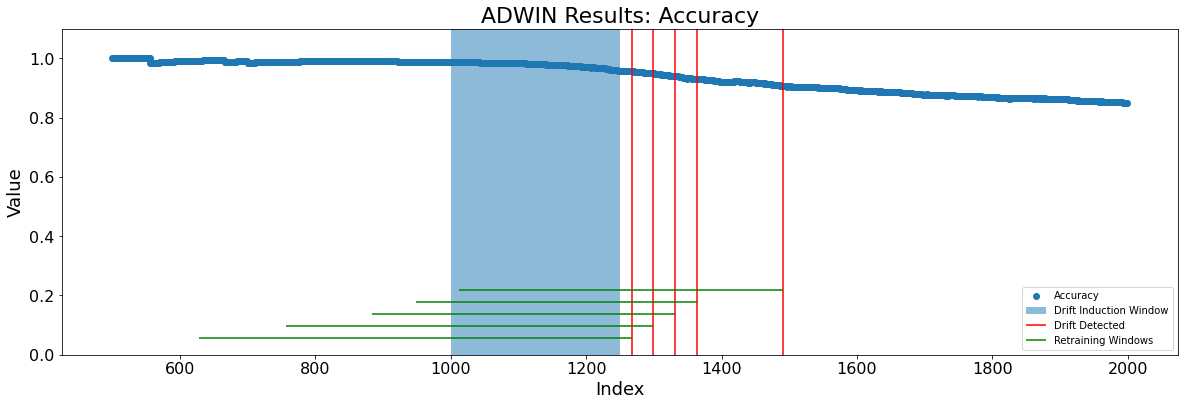

In [9]:
## Plotting ##

plt.figure(figsize=(20, 6))
plt.scatter("index", "accuracy", data=status, label="Accuracy")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADWIN Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [0, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend(loc='lower right')
plt.show()
# plt.savefig("example_ADWIN.png")


After drift is induced, the accuracy decreases enough for ADWIN to shrink its
window and alarm;  subsequent windows also include data from the old regime,
so drift continues to be detected until the window shrinks enough to be
comprised mostly by the new regime.


## Drift Detection Method (DDM)

DDM can enter either a "drift" or "warning" state, depending on how close a classifier's error rate has approached to those respective thresholds, defined by the warning_scale and drift_scale parameters.

In [ ]:
## Setup ##

np.random.seed(123)
# setup classifier: train on first training_size rows
X_train = df.loc[0:training_size, ["var1", "var2"]]
y_train = df.loc[0:training_size, "y"]
clf = GaussianNB()
clf.fit(X_train, y_train)


These parameter values are chosen somewhat arbitrarily.
At least 100 samples must be seen before DDM tests for drift (the n_threshold
parameter); the other two define the warning and drift regions. The minimum
error rate (and its standard deviation) are found during a stable regime; the
warning_scale and drift_scale roughly correspond to how many standard standard
deviations away the current estimate must be in order for the detector to
alarm.


In [ ]:
ddm = DDM(n_threshold=100, warning_scale=7, drift_scale=10)

# setup DF to store results
status = pd.DataFrame(columns=["index", "y", "y_pred", "drift_detected", "accuracy"])
correct = 0
rec_list = []

In [ ]:
# run DDM and retrain
n = 1
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ["var1", "var2"]]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "y"])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    ddm.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, ddm.drift_state, accuracy]

    # If drift is detected, examine the window and retrain.
    if ddm.drift_state == "drift":
        retrain_start = ddm.retraining_recs[0] + training_size
        retrain_end = ddm.retraining_recs[1] + training_size
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ["var1", "var2"]]
        y_train = df.loc[retrain_start:retrain_end, "y"]
        clf = GaussianNB()
        clf.fit(X_train, y_train)

    n += 1

In [ ]:
## Plotting ##

plt.figure(figsize=(20, 6))
plt.scatter("index", "accuracy", data=status, label="Accuracy")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("DDM Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
    linewidth=3,
)

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend()


DDM initially alarms during the drift induction window, triggering retraining.
The subsequent dip in accuracy is large enough to put the detector in the
"warning" state, but not large enough for "drift" to be identified.



In [ ]:
plt.show()
# plt.savefig("example_DDM.png")

## Early Drift Detection Method (EDDM)

EDDM monitors the distance between two errors of a classifier - i.e., the number of samples between errors - rather than monitoring the error rate itself. Similar to DDM, it uses separate thresholds for "warning" and "drift."

In [ ]:
## Setup ##

np.random.seed(123)
# setup classifier: train on first 500 rows
X_train = df.loc[0:training_size, ["var1", "var2"]]
y_train = df.loc[0:training_size, "y"]
clf = GaussianNB()
clf.fit(X_train, y_train)

- n_threshold specifies the number of new samples which must be observed before
tests for drift are run.

- The warning_thresh and drift_thresh values roughly correspond to the ratio of
the 95th percentile for the current distance distribution vs. the 95th percentile
for the "best" distance distribution observed so far. So, lower values correspond to less conservative monitoring - the current
distance between errors is allowed to be a smaller fraction of the "best"
distance.


In [ ]:
eddm = EDDM(n_threshold=30, warning_thresh=0.7, drift_thresh=0.5)

# setup DF to store results
status = pd.DataFrame(columns=["index", "y", "y_pred", "drift_detected", "accuracy"])
correct = 0
rec_list = []

In [ ]:
# run EDDM and retrain
n = 1
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ["var1", "var2"]]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "y"])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    eddm.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, eddm.drift_state, accuracy]

    # If drift is detected, examine the window and retrain.
    if eddm.drift_state == "drift":
        retrain_start = eddm.retraining_recs[0] + training_size
        retrain_end = eddm.retraining_recs[1] + training_size
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ["var1", "var2"]]
        y_train = df.loc[retrain_start:retrain_end, "y"]
        clf = GaussianNB()
        clf.fit(X_train, y_train)

    n += 1

In [ ]:
## Plotting ##

plt.figure(figsize=(20, 6))
plt.scatter("index", "accuracy", data=status, label="Accuracy")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EDDM Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
    alpha=0.3,
)

plt.legend()

EDDM enters a drift state shortly after the drift induction window, triggering
retraining. The later increase in the error rate causes the detector to enter
the warning state, but is not large enough to be identified as drift with this
threshold setting.


In [ ]:
plt.show()
# plt.savefig("example_EDDM.png")

## Statistical Test of Equal Proportions to Detect Concept Drift (STEPD)

STEPD is a detector specifically intended for online classifiers, where each new sample is used to update the parameters of the classifier. STEPD monitors the accuracy in two windows, "recent" and "past," and compares those in order to detect drift in classifier accuracy.

In [ ]:
## Setup ##

np.random.seed(123)
df_ex = df
train_ix = [0, training_size]


# For the purposes of this example, our online classifier is an SGDClassifier
# with a constant learning rate, since this is available in the pre-existing
# package dependency sklearn.
clf = SGDClassifier(learning_rate="constant", shuffle=False, eta0=0.2)
clf.fit(
    df_ex.loc[train_ix[0] : train_ix[1], ["var1", "var2"]].values,
    df_ex.loc[train_ix[0] : train_ix[1], "y"].values,
)


stepd = STEPD(window_size=100)

# setup DF to store results
status = pd.DataFrame(columns=["index", "y", "y_pred", "drift_detected", "accuracy"])
correct = 0
rec_list = []

In [ ]:
# run STEPD and retrain
n = 1
for i, row in df_ex.iloc[training_size:].iterrows():
    y_pred = clf.predict(np.array(row[["var1", "var2"]]).reshape(1, -1))
    y_true = row["y"]

    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    stepd.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, stepd.drift_state, accuracy]
    # train_ix[1] = train_ix[1] + 1

    if stepd.drift_state == "drift":
        rec_list.append(stepd.retraining_recs)
        # retrain the classifier using STEPD's recommendations
        train_ix = stepd.retraining_recs
        train_ix[0] = train_ix[0] + training_size  # adjust for starting index
        train_ix[1] = train_ix[1] + training_size
        clf.fit(
            df_ex.loc[train_ix[0] : train_ix[1], ["var1", "var2"]].values,
            df_ex.loc[train_ix[0] : train_ix[1], "y"].values,
        )

    else:
        # update the classifier with the newest sample
        clf.partial_fit(row[["var1", "var2"]].values.reshape(1, -1), [row["y"]])

    n += 1

In [ ]:
## Plotting ##

plt.figure(figsize=(20, 6))
plt.scatter("index", "accuracy", data=status, label="Accuracy")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("STEPD Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
    linewidth=3,
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend(loc='upper left')

STEPD identifies drift quite early in the drift induction window, triggering
retraining on a relatively small amount of data; after this, the online
classifier updates sufficiently that its accuracy is roughly flat over the
remaining data, albeit with a big enough change to trigger more warnings.


In [ ]:
plt.show()
# plt.savefig("example_STEPD.png")

## Margin Density Drift Detection (MD3) Method

MD3 is a detector intended for semi-supervised and online classifier contexts. A cumulative margin density statistic (unsupervised) is tracked, representing the number of samples that fall into the uncertainty region, or margin, of the classifier. When margin density increases or decreases beyond a certain threshold, a drift warning is issued. When a warning is issued, a set of labeled samples is requested. If prediction accuracy by the model on these samples is lower than on the initial labeled reference dataset, drift is confirmed. If not, drift is ruled out.

In [ ]:
## Setup ##

# Set up classifier: train on first training_size rows
training_data = rainfall_df.loc[0:rainfall_training_size, rainfall_columns]
X_train = rainfall_df.loc[0:rainfall_training_size, rainfall_features]
y_train = rainfall_df.loc[0:rainfall_training_size, "rain"]

np.random.seed(123)
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train.values.ravel())
retrain_clf = clone(clf)
retrain_clf.fit(X_train, y_train.values.ravel())
oracle_labels = 1000

# Initialize detector
md3 = MD3(clf=clf, sensitivity=1.5, oracle_data_length_required=oracle_labels)
md3.set_reference(X=training_data, target_name="rain")

# Set up DF to record results.
status = pd.DataFrame(
    columns=["index", "y", "margin_density", "original_accuracy", "retrain_accuracy", "drift_detected"]
)
correct_orig, correct_retrain = 0, 0
n = 1
rec_list = []
oracle_list = []

In [ ]:
# run MD3 and track results for both original model and retrained model
for i in range(rainfall_training_size, len(rainfall_df)):

    X_test = rainfall_df.loc[[i], rainfall_features]
    y_pred_orig = int(clf.predict(X_test))
    y_pred_retrain = int(retrain_clf.predict(X_test))
    y_true = int(rainfall_df.loc[[i], "rain"])
    
    # increment accuracy
    if y_pred_orig == y_true:
        correct_orig += 1
    if y_pred_retrain == y_true:
        correct_retrain += 1
    accuracy_orig = correct_orig / n
    accuracy_retrain = correct_retrain / n

    # call give_oracle_label if detector is currently waiting for oracle data
    if md3.waiting_for_oracle == True:
        oracle_label = rainfall_df.loc[[i], rainfall_columns]
        md3.give_oracle_label(oracle_label)
        if md3.waiting_for_oracle == False:
            retrain_clf.fit(md3.reference_batch_features, md3.reference_batch_target.values.ravel())
        status.loc[i] = [
            i,
            y_true,
            None,
            accuracy_orig,
            accuracy_retrain,
            md3.drift_state,
        ]

    # call update otherwise
    else:
        md3.update(X_test)
        status.loc[i] = [
            i,
            y_true,
            md3.curr_margin_density,
            accuracy_orig,
            accuracy_retrain,
            md3.drift_state,
        ]
    
    # If there was a drift warning, track the window of the labeled
    # oracle data used
    if md3.drift_state == "warning":
        oracle_start = i + 1
        oracle_end = i + md3.oracle_data_length_required
        
        oracle_list.append([oracle_start, oracle_end])

    n += 1

In [ ]:
## Plotting ##

plt.figure(figsize=(20, 6))
plt.scatter("index", "margin_density", data=status, label="Margin Density")
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color="red")
plt.scatter("index", "retrain_accuracy", data=status, label="Retrain Accuracy", color="green")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("MD3 Results: Margin Density and Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(rainfall_drift_start, rainfall_drift_end, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
oracle_list = pd.DataFrame(oracle_list)
oracle_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(oracle_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=oracle_list["y_val"],
    xmin=oracle_list[0],
    xmax=oracle_list[1],
    color="green",
    label="Labeled Oracle Data",
)

plt.legend()

After drift is induced, the margin density decreases enough for MD3 to emit a warning. From there, the predictive accuracy of the classifier is tested, and this has already decreased sufficiently for the detector to alarm. Then, a new reference batch is set and the detector continues tracking the margin density statistic until the next warning. It can be seen from the plot that retraining at drift results in better accuracy moving forward compared with a model that is kept static.

In [ ]:
plt.show()
# plt.savefig("example_MD3.png")